In [35]:
""" IMPORTS """

import os
import re
from pathlib import Path

import numpy as np
import scipy as sp
import scipy.spatial
import math

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.tri as tri

from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot
import shutil
from tqdm import tqdm

import ipynbname
import torch
from torch.autograd.functional import jacobian

import multiprocessing as mp

## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


# Experiments to stabilize distance lanscapes


# Utils

In [36]:
def find_last_run_folder(base_dir, prefix="run_"):
    """
    Finds the last run folder (e.g., run_01, run_02, ...) inside base_dir.
    Returns the full path of the last folder.
    """
    pattern = re.compile(rf"{prefix}(\d+)$")
    max_n = -1
    last_folder = None

    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            n = int(match.group(1))
            if n > max_n:
                max_n = n
                last_folder = os.path.join(base_dir, name)

    return last_folder


def next_landscape_filename(
    base_dir,
    subfolder="landscapes",
    prefix="landscape_",
    ext=".npz",
    width=2,
):
    base_dir = Path(base_dir)
    folder = base_dir / subfolder
    folder.mkdir(parents=True, exist_ok=True)

    pattern = re.compile(
        rf"{re.escape(prefix)}(\d{{{width}}}){re.escape(ext)}"
    )

    max_idx = 0
    for f in folder.iterdir():
        m = pattern.fullmatch(f.name)
        if m:
            max_idx = max(max_idx, int(m.group(1)))

    next_idx = max_idx + 1
    name = f"{prefix}{next_idx:0{width}d}{ext}"
    return folder / name

def last_landscape_filename(
    base_dir,
    subfolder="landscapes",
    prefix="landscape_",
    ext=".npz",
    width=2,
):
    base_dir = Path(base_dir)
    folder = base_dir / subfolder
    folder.mkdir(parents=True, exist_ok=True)

    pattern = re.compile(
        rf"{re.escape(prefix)}(\d{{{width}}}){re.escape(ext)}"
    )

    max_idx = 0
    for f in folder.iterdir():
        m = pattern.fullmatch(f.name)
        if m:
            max_idx = max(max_idx, int(m.group(1)))

    next_idx = max_idx
    name = f"{prefix}{next_idx:0{width}d}{ext}"
    return folder / name

In [37]:
import secrets

def simplex_grid(N=20):
    """Generate points on a 2D simplex grid (triangle) with N divisions per edge."""    
    N = N
    pts = []
    for l in range(N + 1):
        for j in range(N + 1 - l):
            k = N - l - j
            pts.append((l / N, j / N, k / N))
    pts=np.array(pts)
    return pts

def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    if seed is None:
        seed = secrets.randbits(256)
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp, seed


def plot_point_cloud(pts, title='Point Cloud'):
    """Plot 2D point cloud. pts is (N, 2) array."""
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

def compute_distance_matrix(pts):
    """Compute pairwise Euclidean distance matrix for pts."""
    diff = pts[:, None, :] - pts[None, :, :]  # (N, N, 2)
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))  # (N, N)
    return dist_matrix  

def get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem.

    Input:
      matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
      measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
      matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
      measure_input: Probability vector of length M (array)

    Output:
      F_list: List of auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem. (list of arrays)
    '''

    S = len(matrix_temp_list)  # Number of template matrices

    pi_list = []  # List to store Gromov-Wasserstein transport plans
    F_list = []  # List to store transformed matrices

    # Compute Q matrix (inverse of the outer product of measure_input)
    Q = (measure_input.reshape(-1, 1) @ measure_input.reshape(1, -1))
    Q = 1. / Q  # Element-wise inverse

    # Compute Gromov-Wasserstein transport maps and one iteration of the forward GW-barycenter problem
    for s in range(S):
        # Compute optimal transport plan (pi_s) using Gromov-Wasserstein transport
        pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s], matrix_input,
                                            measure_temp_list[s], measure_input)
        pi_list.append(pi_s)

        # Compute F_s transformation using Q and pi_s
        F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)  # Element-wise multiplication
        F_list.append(F_s)
    
    return F_list

def get_norm_F(lambdas, matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the F norm of the difference between the weighted sum of auxiliary matrices F_s and the input.

    Input:
        lambdas: Weights for each template matrix (array of length S).
        matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
        measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
        matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
        measure_input: Probability vector of length M (array)
    Output:
        norm_F: Frobenius norm of the difference between matrix_input and the weighted sum of F_s matrices. (float)
    '''

    F_list = get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input)
    F_weighted_sum = sum(lambdas[s] * F_list[s] for s in range(len(F_list)))
    norm_F = np.linalg.norm(matrix_input - F_weighted_sum, 'fro')
    return norm_F

def get_norm_GW(lambdas, matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the GW norm of the difference between the weighted sum of auxiliary matrices F_s and the input.

    Input:
        lambdas: Weights for each template matrix (array of length S).
        matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
        measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
        matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
        measure_input: Probability vector of length M (array)
    Output:
        norm_F: Frobenius norm of the difference between matrix_input and the weighted sum of F_s matrices. (float)
    '''

    F_list = get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input)
    F_weighted_sum = sum(lambdas[s] * F_list[s] for s in range(len(F_list)))
    norm_GW, log_GW = ot.gromov.gromov_wasserstein2(matrix_input, F_weighted_sum, ot.unif(matrix_input.shape[0]), ot.unif(F_weighted_sum.shape[0]), 'square_loss', log=True)
    return log_GW['gw_dist']

def get_bary_functional_value(
    lambdas,
    matrix_temp_list,
    measure_temp_list,
    matrix_input,
    measure_input,
    loss_fun="square_loss"
):
    """
    Computes the GW barycenter functional value using POT.

    Parameters
    ----------
    lambdas : array-like, shape (S,)
        Barycenter weights (should sum to 1).
    matrix_temp_list : list of ndarray
        Distance matrices C_s of templates.
    measure_temp_list : list of ndarray
        Probability measures p_s of templates.
    matrix_input : ndarray
        Distance matrix C of the candidate barycenter.
    measure_input : ndarray
        Probability measure q of the candidate barycenter.
    loss_fun : str
        'square_loss' (default) or 'kl_loss'

    Returns
    -------
    float
        GW barycenter functional value
    """
    value = 0.0

    for lam, C_s, p_s in zip(
        lambdas, matrix_temp_list, measure_temp_list
    ):
        gw2 = ot.gromov.gromov_wasserstein2(
            matrix_input,
            C_s,
            measure_input,
            p_s,
            loss_fun=loss_fun,
            verbose=False
        )
        value += lam * gw2

    return value

def improved_synth(weights, matrix_temp_list, measure_temp_list):
    ot_bary = ot.gromov.gromov_barycenters(
        matrix_temp_list[0].shape[0], 
        Cs = matrix_temp_list, 
        lambdas=weights, 
        loss_fun='square_loss'
        )
    F_list = get_Fs(matrix_temp_list, measure_temp_list, ot_bary, ot.unif(ot_bary.shape[0]))
    improved_bary = sum(weights[s] * F_list[s] for s in range(len(F_list)))
    #print(np.linalg.norm(ot_bary-improved_bary,'fro'))
    return improved_bary


In [38]:
import signal 

# ----------------------------------------------
# Set up signal handler for timeout with custom exception
# ----------------------------------------------

# Creates a custom exception to be raised by the handler and test in except blocks
class TimeoutException(Exception): 
    pass
# Custom signal handler that is called when the signal is received
def timeout_handler(signum, frame): 
    raise TimeoutException

# Set the signal handler for SIGALRM to our custom handler
signal.signal(signal.SIGALRM, timeout_handler) 

<function __main__.timeout_handler(signum, frame)>

# Select experiment folder and options for the experiment

In [39]:
# ----------------------------------------------
# Choose experiment base directory
# ----------------------------------------------
base_dir = Path('./20-Exp-generated_data')
output_dir = Path(os.path.join(base_dir, 'run_10'))
#output_dir = Path(find_last_run_folder(base_dir, prefix="run_"))

# ----------------------------------------------
# Choose if generate or only load and plot
# ----------------------------------------------
generate = True
n_grid_points = 20

# ----------------------------------------------
# Choose if loading plotting and saving plots
# ----------------------------------------------
load_and_plot = True

# ----------------------------------------------
# Choose if analysing the variability of a synthetized barycenter
# ----------------------------------------------
variability = True




## Generate and save landscapes via filtering best sythetized barycenter according to GW error.

In [ ]:
""" Create landscape data and save to landscape_##.npz """
if generate: 
    #------------------------------------------------------------
    # Plot distances to targets in Frobernius and GW cases when targets are different sythetized matrices of the same lambda weights
    #------------------------------------------------------------

    # Select target weights
    lambda_test  = np.array([0.3, 0.4, 0.3])

    # Load first three deformed point clouds   
    assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
    deformed_dist_matrices = []
    deformed_measures = []
    for idx in range(1, 4):
        deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
        deformed_pts = deformed_data['points']
        deformed_dist_matrix = deformed_data['distance_matrix']
        deformed_dist_matrices.append(deformed_dist_matrix)
        deformed_measures.append(ot.unif(deformed_dist_matrix.shape[0]))

    distance_data = []
    recovered_lambdas = []
    for _ in range(3):
        # ------------------------------------------------------------
        # Computre target as the barycenter that minimizes the functional among ten local minima
        # ------------------------------------------------------------
        running_error = np.inf
        for target_attempt in range(10):
            target_dist_matrix_synth = ot.gromov.gromov_barycenters(
                deformed_dist_matrices[0].shape[0], 
                Cs = deformed_dist_matrices, 
                lambdas=lambda_test, 
                loss_fun='square_loss'
                )
            B_blowup, b_blowup, temp_blow_up = utils.blow_up(deformed_dist_matrices, deformed_measures, target_dist_matrix_synth, ot.unif(target_dist_matrix_synth.shape[0]))
            a = utils.get_lambdas_blowup_matrix(temp_blow_up, B_blowup, b_blowup)

            error_GW = get_bary_functional_value(lambda_test, deformed_dist_matrices, deformed_measures, target_dist_matrix_synth, ot.unif(target_dist_matrix_synth.shape[0]))

            if math.isclose(a, 0.0, rel_tol=1e-12, abs_tol=1e-15) and error_GW < running_error:
                best_target = target_dist_matrix_synth
        target_dist_matrix_synth = best_target


        # ----------------------------------------------------------
        # Compute distances to elements in grid
        # ----------------------------------------------------------

        
        simplex_grid_points = simplex_grid(N=n_grid_points)
        simplex_GW_distances_to_target = []
        for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
            weights = weight / np.sum(weight)  # Normalize to sum to 1
            try:
                running_error = np.inf
                for bary_attempt in range(10):
                    #print(bary_attempt)
                    true_bary = False
                    signal.alarm(3)
                    barycenter_dist_matrix, log = ot.gromov.gromov_barycenters(
                        deformed_dist_matrices[0].shape[0], 
                        Cs = deformed_dist_matrices, 
                        lambdas=weights, 
                        loss_fun='square_loss',
                        log=True
                    )
                    signal.alarm(0)  # Disable the alarm
                    B_blowup, b_blowup, temp_blow_up = utils.blow_up(deformed_dist_matrices, deformed_measures, barycenter_dist_matrix, ot.unif(barycenter_dist_matrix.shape[0]))
                    a = utils.get_lambdas_blowup_matrix(temp_blow_up, B_blowup, b_blowup) # Test if gradient is close to zero with blow-up
                    error_GW = get_bary_functional_value(weights, deformed_dist_matrices, deformed_measures, barycenter_dist_matrix, ot.unif(barycenter_dist_matrix.shape[0]))
                    # error_GW = get_norm_GW(weights, deformed_dist_matrices, deformed_measures, barycenter_dist_matrix, ot.unif(barycenter_dist_matrix.shape[0]))

                    # TODO: test different ways of choosing the best synthetized barycenter 
                    # Compute error between input weights and recomputed weights from blow-up matrices
                    # Use the a value from blow-up method test
                    # Use the error from the other test (fixed point approach)

                    if math.isclose(a, 0.0, rel_tol=1e-12, abs_tol=1e-15) and error_GW < running_error:
                        gw_dist_to_target = ot.gromov.gromov_wasserstein2(
                            barycenter_dist_matrix,
                            target_dist_matrix_synth,
                            ot.unif(barycenter_dist_matrix.shape[0]),
                            ot.unif(target_dist_matrix_synth.shape[0]),
                            'square_loss'
                            )
                        running_error = error_GW
                        best_gw_dist_to_target = gw_dist_to_target

                simplex_GW_distances_to_target.append(best_gw_dist_to_target)
                true_bary = True
                        
                #print(f'True bary at {weights}')
                        
                #print('About to check')    
                if  not true_bary:
                    #print(f'Not true bary found at {weights}')
                    raise TimeoutException
                
            except TimeoutException:
                simplex_GW_distances_to_target.append(np.nan)
                #print('Added NaN')        


        # Clean up NaN values for plotting
        distance_data.append(simplex_GW_distances_to_target)
        _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_synth, ot.unif(target_dist_matrix_synth.shape[0]))
        recovered_lambdas.append(lambdas)
        


    notes = "Synthetized barycenters at each grid point selected among different attempts. All attempts tested to have blow-up zero gradient. Synthetized barycenter chosen as minimizer of fixed point error among the attempts."
    fname = next_landscape_filename(base_dir=output_dir, subfolder="landscapes")    
    np.savez(fname,target=lambda_test,recovered_lambdas = recovered_lambdas, simplex_grid_points = simplex_grid_points, landscape_data = distance_data, notes = notes)

100%|██████████| 231/231 [07:11<00:00,  1.87s/it]


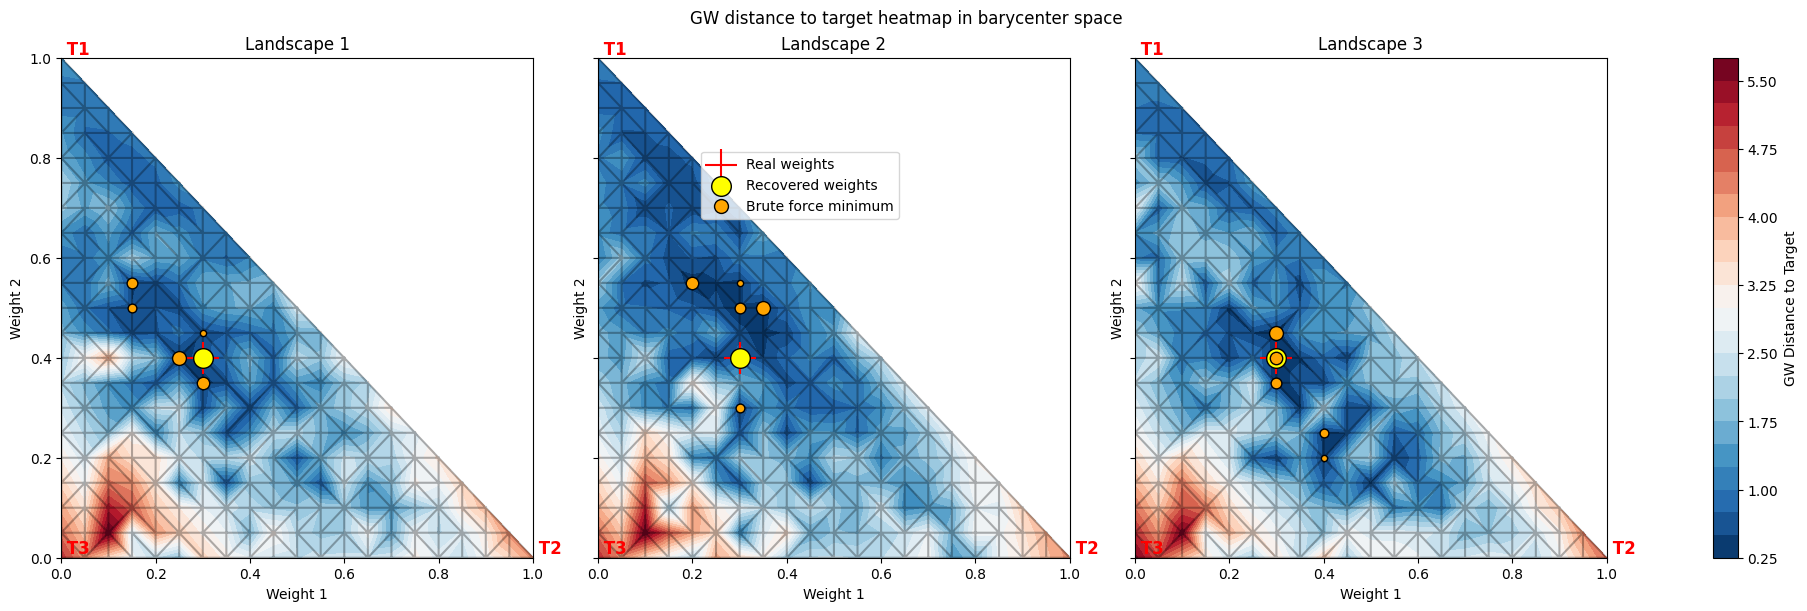

In [41]:
""" Load last landscape data and plot 3 landscapes in one figure"""
if load_and_plot:

    load_fname = last_landscape_filename(base_dir=output_dir,subfolder="landscapes")




    with np.load(load_fname) as data:
        lambda_test = data['target']
        simplex_grid_points = data['simplex_grid_points']

        # --- create figure with 3 rows ---
        fig, axes = plt.subplots(
            nrows=1, ncols=3,
            figsize=(18, 6),
            sharey=True,
            constrained_layout=True
        )

        contour = None  # will hold last contour for colorbar

        for ax, idx in zip(axes, range(3)):
            simplex_GW_distances_to_target = data['landscape_data'][idx]
            lambdas = data['recovered_lambdas'][idx]

            # Clean NaNs
            z = np.asarray(simplex_GW_distances_to_target)
            mask = np.isnan(z)

            z_masked = z[~mask]
            x_grid = simplex_grid_points[~mask, 0]
            y_grid = simplex_grid_points[~mask, 1]

            min_simplex_grid_points = simplex_grid_points[z.argsort()[:5]]

            # --- contour plot ---
            contour = ax.tricontourf(
                x_grid, y_grid, z_masked,
                levels=24,
                cmap="RdBu_r"
            )

            # --- triangulation grid ---
            triang = tri.Triangulation(x_grid, y_grid)
            ax.triplot(triang, color='k', alpha=0.3)

            # --- points ---
            ax.scatter(
                lambda_test[0], lambda_test[1],
                marker='+', color='red', s=500,
                label='Real weights'
            )
            ax.scatter(
                lambdas[0], lambdas[1],
                color='yellow', s=200,
                edgecolor='k', label='Recovered weights'
            )

            for j, p in enumerate(min_simplex_grid_points):
                ax.scatter(
                    p[0], p[1],
                    color='orange',
                    s=100 - 20*j,
                    edgecolor='k', 
                    label = 'Brute force minimum' if j == 0 else None
                )

            ax.set_xlabel('Weight 1')
            ax.set_ylabel('Weight 2')
            ax.set_title(f'Landscape {idx + 1}')

            ax.text(0, 0, " T3", color="red", fontsize=12, va="bottom", fontweight='bold')
            ax.text(0, 1, " T1", color="red", fontsize=12, va="bottom", fontweight='bold')
            ax.text(1, 0, " T2", color="red", fontsize=12, va="bottom", fontweight='bold')

        # --- single shared colorbar ---
        cbar = fig.colorbar(contour, ax=axes, shrink=1)
        cbar.set_label('GW Distance to Target')


        fig.suptitle('GW distance to target heatmap in barycenter space')
        

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(
            handles, labels,
            loc="center right",
            bbox_to_anchor=(0.5, 0.7),
            frameon=True
            )
        
        save_name = f"{load_fname}_triplots.png"
        plt.savefig(save_name)
        plt.show()

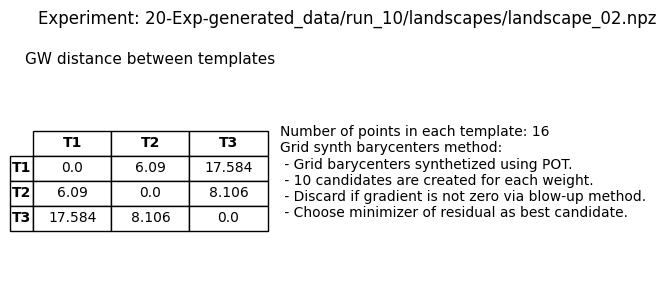

In [42]:
""" Load last landscape templates. Compute GW distance matrix between them. Add experiment parameters as text to figure. """
with np.load(output_dir / 'template_point_cloud.npz') as template_point_cloud:
    n_points_in_templates = template_point_cloud['distance_matrix'].shape


# Generate distance matrix between templates
gw_distance_matrix = np.zeros((3, 3))
for i in range(0, 3):
    for j in range(i + 1, 3):
        data_i = np.load(output_dir / f'deformed_point_cloud_{i+1}.npz')
        data_j = np.load(output_dir / f'deformed_point_cloud_{j+1}.npz')
        dist_matrix_i = data_i['distance_matrix']
        dist_matrix_j = data_j['distance_matrix']
        gw_dist = ot.gromov.gromov_wasserstein2(
            dist_matrix_i,
            dist_matrix_j,
            ot.unif(dist_matrix_i.shape[0]),
            ot.unif(dist_matrix_j.shape[0]),
            'square_loss'
        )
        gw_distance_matrix[i, j] = gw_dist
        gw_distance_matrix[j, i] = gw_dist   


# -----------------------------
# Figure: ONE ROW, TWO COLUMNS
# -----------------------------
fig = plt.figure(figsize=(7, 3))

gs = GridSpec(
    nrows=1,
    ncols=2,
    width_ratios=[1, 2],
    figure=fig
)

# -----------------------------
# Left: matrix table
# -----------------------------
ax_table = fig.add_subplot(gs[0])
ax_table.axis("off")

row_labels = ["T1", "T2", "T3"]
col_labels = ["T1", "T2", "T3"]

table = ax_table.table(
    cellText=np.round(gw_distance_matrix, 3),
    rowLabels=row_labels,
    colLabels=col_labels,
    cellLoc="center",
    loc="center"
)

table.scale(1.3, 1.6)

# Bold headers
for (r, c), cell in table.get_celld().items():
    if r == 0 or c == -1:
        cell.set_text_props(fontweight="bold")

ax_table.set_title("GW distance between templates", fontsize=11)

# -----------------------------
# Right: parameters / text
# -----------------------------
ax_text = fig.add_subplot(gs[1])
ax_text.axis("off")

param_text = (
    f"Number of points in each template: {n_points_in_templates[0]}\n"
    "Grid synth barycenters method:\n"
    " - Grid barycenters synthetized using POT.\n"
    " - 10 candidates are created for each weight.\n"
    " - Discard if gradient is not zero via blow-up method. \n"
    " - Choose minimizer of residual as best candidate.\n"
)

ax_text.text(
    0.0, 0.5,
    param_text,
    va="center",
    fontsize=10,
    wrap=True
)

fig.suptitle(f"Experiment: {load_fname}")
plt.tight_layout()

save_name = f"{load_fname}_dataplot.png"
plt.savefig(save_name)
plt.show()

In [43]:
%%script false --no-raise-error
# ----------------------------------------------
# Choose experiment base directory
# ----------------------------------------------
#base_dir = Path('./20-Exp-generated_data')
#output_dir = Path(os.path.join(base_dir, 'run_06'))
output_dir = output_dir



# ----------------------------------------------
# Load last landscape data and plot independently
#----------------------------------------------
load_fname = last_landscape_filename(base_dir=output_dir,subfolder="landscapes")
with np.load(load_fname) as data:
    lambda_test = data['target']
    simplex_grid_points = data['simplex_grid_points']
    for idx in range(len(data['landscape_data'])):
        # Load distance data on grid and recovered lambdas
        simplex_GW_distances_to_target = data['landscape_data'][idx]
        lambdas = data['recovered_lambdas'][idx]
        
        # Clean up NaN values for plotting
        z = np.array(simplex_GW_distances_to_target)
        mask = np.isnan(z)
        z_masked = z[~mask]
        x_grid_points = simplex_grid_points[~mask,0]
        y_grid_points = simplex_grid_points[~mask,1]
        min_simplex_grid_points = simplex_grid_points[z.argsort()[:5]]

        # Plot GW distances to target vs. simplex weights
        plt.figure(figsize=(6,4))
        plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=24, cmap="RdBu_r")
        plt.colorbar(label='GW Distance to Target')
        plt.xlabel('Weight 1')
        plt.ylabel('Weight 2')
        plt.title('GW Distance to Target (in barycenter space) vs. Simplex Weights')

        # Plot triangulation grid
        triang = tri.Triangulation(x_grid_points, y_grid_points)
        plt.triplot(triang, color='k', alpha=0.3)

        # Plot true and recovered weights
        plt.scatter(lambda_test[0], lambda_test[1], marker = '+',  color='red', s=500, edgecolor='k', label='Target')
        plt.scatter(lambdas[0], lambdas[1], color='yellow', s=200, edgecolor='k', label='Computed Weights our algorithm')
        for index, min_point in enumerate(min_simplex_grid_points):
            plt.scatter(min_point[0], min_point[1], color='orange', s=100-20*index, edgecolor='k', label=f'GW Min Weights N {index+1}')
        #plt.legend()
        plt.show()

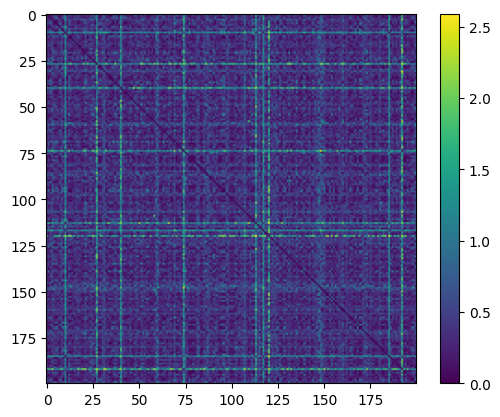

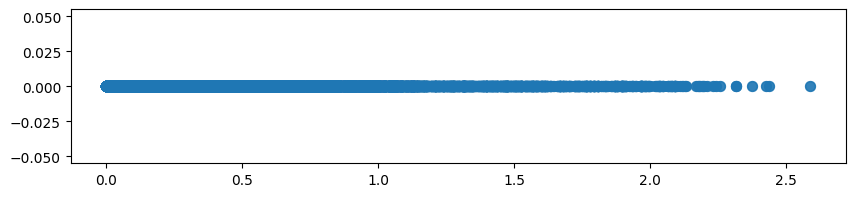

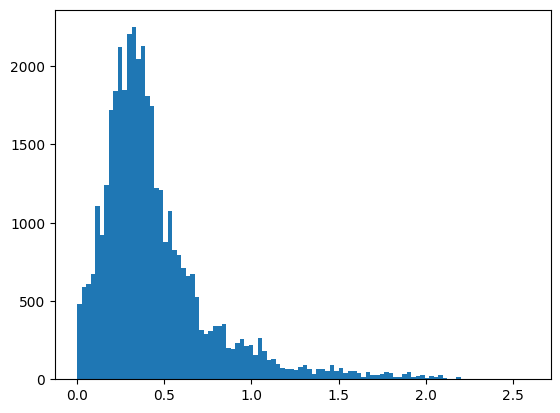

min: 4.440892098500626e-16


/tmp/ipykernel_2934144/2559499996.py:78: RuntimeWarning: invalid value encountered in log
  log_data = np.log(flattened_data)


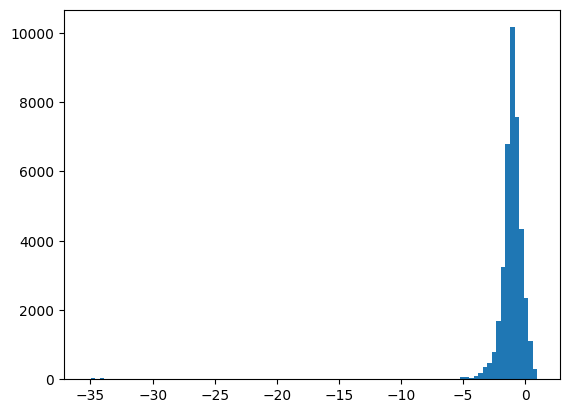

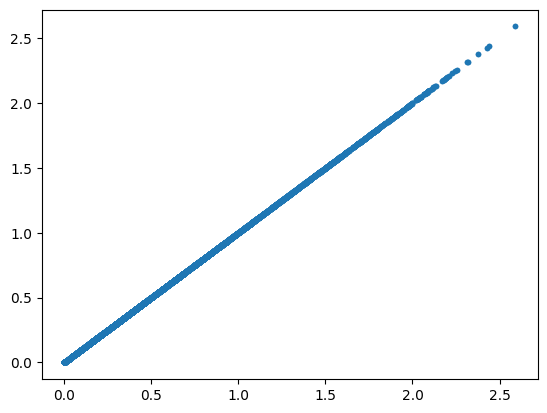

In [44]:
""" Variability of barycenter """

def GW_distance_between_graphs(graph_list):
    # Generate distance matrix between templates
    n = len(graph_list)
    gw_distance_matrix = np.zeros((n, n))
    for i in range(0, n):
        for j in range(i + 1, n):
            dist_matrix_i = graph_list[i]
            dist_matrix_j = graph_list[j]
            gw_dist = ot.gromov.gromov_wasserstein2(
                dist_matrix_i,
                dist_matrix_j,
                ot.unif(dist_matrix_i.shape[0]),
                ot.unif(dist_matrix_j.shape[0]),
                'square_loss'
            )
            gw_distance_matrix[i, j] = gw_dist
            gw_distance_matrix[j, i] = gw_dist   
    return gw_distance_matrix


if variability:
    # Load first three deformed point clouds   
    assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
    deformed_dist_matrices = []
    deformed_measures = []
    for idx in range(1, 4):
        deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
        deformed_pts = deformed_data['points']
        deformed_dist_matrix = deformed_data['distance_matrix']
        deformed_dist_matrices.append(deformed_dist_matrix)
        deformed_measures.append(ot.unif(deformed_dist_matrix.shape[0]))

    bary_list = []
    for _ in range(200):
        # ------------------------------------------------------------
        # Computre GW distances to original target and plot results
        # ------------------------------------------------------------
        for target_attempt in range(10):
            target_dist_matrix_synth = ot.gromov.gromov_barycenters(
                deformed_dist_matrices[0].shape[0], 
                Cs = deformed_dist_matrices, 
                lambdas=lambda_test, 
                loss_fun='square_loss'
                )
            B_blowup, b_blowup, temp_blow_up = utils.blow_up(deformed_dist_matrices, deformed_measures, target_dist_matrix_synth, ot.unif(target_dist_matrix_synth.shape[0]))
            a = utils.get_lambdas_blowup_matrix(temp_blow_up, B_blowup, b_blowup)

            if math.isclose(a, 0.0, rel_tol=1e-12, abs_tol=1e-15):
                bary_list.append(target_dist_matrix_synth)
                break
                

np.set_printoptions(precision=2, suppress=False, linewidth=1000)

dist_between_repetitions = GW_distance_between_graphs(bary_list)
#print(dist_between_repetitions)
plt.imshow(dist_between_repetitions)
plt.colorbar()
plt.show()
#print(np.min(dist_between_repetitions), np.max(dist_between_repetitions))

# Scatter plot
flattened_data = dist_between_repetitions.flatten()
y_values = np.zeros_like(flattened_data) # Creates an array of zeros with the same shape as flattened_data

plt.figure(figsize=(10, 2)) # Adjust figure size for a better horizontal view
plt.scatter(np.abs(flattened_data), y_values, alpha=0.7, s=50) 
plt.show()

flattened_data = flattened_data[flattened_data != 0]

plt.hist(np.abs(flattened_data),bins=100)
plt.show()

print(f'min: {np.min(np.abs(flattened_data))}')
log_data = np.log(flattened_data)
log_data = log_data[np.isfinite(log_data)]
plt.hist(log_data, bins = 100, )
plt.show()


flattened_data.sort()
plt.plot(flattened_data,flattened_data,'.')


